## 사전 준비 (pre-requirements)

- 미설치 라이브러리 : gensim
- 구글 드라이브 연결 : /gdrive
- 핵심 라이브러리 : tensorflow

In [ ]:
# 설치전 gensim==3.6.0
!pip install gensim==3.8.3 -U

import gensim
gensim.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'3.8.3'

In [1]:
from google.colab import drive
drive.mount('/gdrive')

# 파일을 못찾을 경우, 이렇게 확인을 해야 함!!
import os
os.chdir("/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석")
!ls -l data

Mounted at /gdrive
total 52701
-rw------- 1 root root  188900 Jul  7 08:13 sample_submission.csv
-rw------- 1 root root  188888 Jul 25 09:17 submission_v2.csv
-rw------- 1 root root  188889 Jul 25 09:11 submission_v3.csv
-rw------- 1 root root  188889 Jul 25 13:52 submission_v4.csv
-rw------- 1 root root 2679138 Jul  7 08:13 test.csv
-rw------- 1 root root 8288753 Jul 24 11:11 test_mecab.csv
-rw------- 1 root root 7841571 Jul 24 11:35 test_okt.csv
-rw------- 1 root root 7650515 Jul 25 08:57 test_okt_stem.csv
-rw------- 1 root root 2738015 Jul  7 08:13 train.csv
-rw------- 1 root root 8366728 Jul 24 11:09 train_mecab.csv
-rw------- 1 root root 7916589 Jul 24 11:29 train_okt.csv
-rw------- 1 root root 7726432 Jul 25 07:25 train_okt_stem.csv


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
# tf 라이브러리 또는 tf.keras 라이브러리는 모두 tf로 정의하세요 (번거로워도 헷갈림 방지)
# 그 외의 라이브러리는 from&import 로 직접 정의 (특히 keras)

np.random.seed(42)
tf.random.set_seed(42)

## 리뷰 평점 예측을 위한 CNN 모델

### 전체 과정

1. 데이터 준비
  - train_df 읽어오기
  - train, valid 분리
  - target(y) 전처리
2. 텍스트 벡터화
  - sequence 변환, 패딩
  - word2vec 로부터 embedding_matrix 준비
3. 모델 생성
  - Embedding Layer
  - 1D CNN Layer
  - Output Layer
4. 모델 훈련
  - optimizer, loss, metrics
  - fit
  - evaluate
5. 모델 활용(예측/분류)
  - 데이터 불러오기: test_df
  - 동일한 전처리와 벡터화 적용
  - predict
6. 모델 시각화 (실제값/예측값)
  - 예측값 시각화
  - 실제값 시각화
  

### 1D CNN 모델

__참고__

- []()

### 1. 데이터 준비

- train_df 읽어오기
- train, valid 분리
- target(y) 전처리


In [ ]:
# data_path = '~/Workspaces/keras/dacon-shopping-mall/review_data'
data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# Okt 토크나이징
# ==> NaN, 한글자 제거 (rows=24981)
file_path = f'{data_path}/train_okt_stem.csv'

## Pickle 로딩
train_df = pd.read_csv(file_path)
# train_df = train_df.drop(['Unnamed: 0'], axis='columns')
print(train_df.shape)

train_df
# 24984 rows × 8 columns

(24984, 8)


,id,reviews,target,mrp_tokens,pos_tokens,mrp_tsize,pos_tsize,pos_csize
0,0,조아요 처음구입 싸게햇어요,2,조아요 처음 구입 싸게 햇 어 요,좋다 처음 구입 싸다 하다,7,5,10
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1,생각 보다 잘 안 돼요 매지 바른지 하루 밖에 안 됐는데 25천원 가량 주고 사기 ...,생각 자다 안 돼다 매다 바르다 하루 안 돼다 주다 사기 너무 아깝다,17,13,26
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2,디자인 은 괜찮은데 상품 이 금 이 가서 교환 했는데 두번째 받은 상품 도 까져있고...,디자인 괜찮다 상품 금 가다 교환 하다 두번째 받다 상품 끄다 안쪽 금 가다 귀찮다...,28,21,46
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2,기전 에 이 제품 말고 이마트 트 레이더스 에서만 팔던 프리미엄 제품 을 사용 했었...,기전 이 제품 이마트 트 레이더스 파다 프리미엄 제품 사용 하다 샘플 써다 보고 마...,53,39,82
4,4,튼튼하고 손목을 잘 받쳐주네요~,5,튼튼하고 손목 을 잘 받쳐주네요 ~,튼튼하다 손목 자다 받치다,6,4,11
...,...,...,...,...,...,...,...,...
24979,24995,일단향이너무너무좋은데지속력만좋다면좋겠지만..워낙저렴해그래도좋아여,5,일단 향 이 너무 너무 좋은데 지속 력 만 좋다면 좋겠지만 .. 워낙 저렴해 그래도...,일단 향 너무 너무 좋다 지속 력 좋다 좋다 워낙 저렴하다 그래도좋아,16,12,27
24980,24996,동일한 업체에서 발송하고 한 상자로 배송되었는데 택배비는 이중 처리되었습니다.,2,동일한 업체 에서 발송 하고 한 상자 로 배송 되었는데 택배 비는 이중 처리 되었습...,동일하다 업체 발송 하다 상자 배송 되어다 택배 비다 이중 처리 되어다,16,12,28
24981,24997,향이 좋아요!! 다른 향도 시켜보고 싶어요,4,향 이 좋아요 !! 다른 향 도 시켜 보고 싶어요,향 좋다 다른 향 시키다 보고 싶다,10,7,13
24982,24998,펼쳐보니 끝부분쯤에 50cm정도 찟어져 있습니다 날짜관계로 구냥 사용합니다,2,펼쳐 보니 끝 부분 쯤 에 50 cm 정도 찟어져 있습니다 날짜 관계 로 구 냥 사...,펼치다 보다 끝 부분 쯤 정도 찟어져 있다 날짜 관계 구 사용 하다,18,13,25


In [ ]:
# LSTM 모델의 출력에 대응하는 target 전처리 : Dim=(None, 5)
# ==> 후처리 시에는 np.argmax([0.0, 0.0, 0.0, 0.0, 1.0])+1 => 5 
#
# target 전처리 https://stackoverflow.com/a/43314437
# target 후처리 https://stackoverflow.com/a/38845674

from keras.utils import np_utils
train_df['t_cate'] = train_df['target'].apply(lambda v: np_utils.to_categorical(v-1, num_classes=5, dtype='float16'))
train_df[['target','t_cate']]

,target,t_cate
0,2,"[0.0, 1.0, 0.0, 0.0, 0.0]"
1,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,2,"[0.0, 1.0, 0.0, 0.0, 0.0]"
3,2,"[0.0, 1.0, 0.0, 0.0, 0.0]"
4,5,"[0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...
24979,5,"[0.0, 0.0, 0.0, 0.0, 1.0]"
24980,2,"[0.0, 1.0, 0.0, 0.0, 0.0]"
24981,4,"[0.0, 0.0, 0.0, 1.0, 0.0]"
24982,2,"[0.0, 1.0, 0.0, 0.0, 0.0]"


In [ ]:
from sklearn.model_selection import train_test_split

data = train_df
X_train, X_valid, y_train, y_valid = train_test_split(
    data[ ['reviews','pos_tokens'] ], 
    data['t_cate'],   # target 대신에 t_cate 사용
    test_size=0.2, 
    random_state=42, 
#     shuffle=True, 
    stratify=data['target']     # 클래스 비율 유지
)

# 동일한 float dtype으로 통일되도록 np.array로 재생성
# ==> 이거 안하면 object 타입으로 인식됨
y_train = np.array( y_train.to_list(), dtype='float16')
print( 'y_train:', type(y_train), y_train.dtype, y_train.shape, y_train[0] )
y_valid = np.array( y_valid.to_list(), dtype='float16')
print( 'y_valid :', type(y_valid), y_valid.dtype, y_valid.shape, y_valid[0] )
print()


# 크기를 확인합니다.
print( 'train 데이터 셋 모양 :', X_train.shape, y_train.shape)
print( 'valid 데이터 셋 모양 :', X_valid.shape, y_valid.shape)

y_train: <class 'numpy.ndarray'> float16 (19987, 5) [0. 1. 0. 0. 0.]
y_valid : <class 'numpy.ndarray'> float16 (4997, 5) [0. 0. 0. 1. 0.]

train 데이터 셋 모양 : (19987, 2) (19987, 5)
valid 데이터 셋 모양 : (4997, 2) (4997, 5)


### 2. 텍스트 벡터화

- sequence 변환, 패딩
- word2vec 로부터 embedding_matrix 준비


In [ ]:
import gensim

ko_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/ko-embeddings"

# ratsgo 기존 모델 + Okt-stem 처리된 코퍼스로 추가 학습
wv_path = ko_path+"/wv_ko_new.bin"
wv_model = gensim.models.Word2Vec.load(wv_path)

print(wv_model.wv.vectors.shape)
# (13123, 100)

(13123, 100)


In [ ]:
# [top-n TFIDF terms](https://stackoverflow.com/a/34236002)
"""
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]
"""

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer = tf.keras.preprocessing.text.Tokenizer()  #num_words = 13123)
tokenizer.fit_on_texts(X_train['pos_tokens'])

# 단어 집합(vocab)의 크기를 입력합니다. 패딩(<pad>)을 고려하여 tokenizer의 단어 수에서 +1 해줍니다.
vocab_size = len(tokenizer.word_index) + 1
print('vocab_size =', vocab_size)

# 단어 대신에 시퀀스(단어 번호)로 변환
X_encoded = tokenizer.texts_to_sequences(X_train['pos_tokens'])

max_len = max(len(sent) for sent in X_encoded)
avg_len = np.mean([len(sent) for sent in X_encoded], dtype=int)
print( 'docs_size=', len(X_encoded))
print( 'max_terms_size=', max_len)
print( 'avg_terms_size=', avg_len)

vocab_size = 12962
docs_size= 19987
max_terms_size= 51
avg_terms_size= 11


In [ ]:
# 패딩
maxlen_pad = 30
X_train_vec= tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=maxlen_pad, padding='post')

print( np.shape(X_train_vec), np.shape(y_train) )
# (19986, 30) (19986,)
y_train[0]

(19987, 30) (19987, 5)


array([0., 1., 0., 0., 0.], dtype=float16)

In [ ]:
# X_valid 에 대해서도 동일 작업
X_encoded = tokenizer.texts_to_sequences(X_valid['pos_tokens'])
X_valid_vec = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=maxlen_pad, padding='post')

print( np.shape(X_valid_vec), np.shape(y_valid) )
# (4997, 30) (4997,)
y_valid[0]

(4997, 30) (4997, 5)


array([0., 0., 0., 1., 0.], dtype=float16)

In [ ]:
# wv_model 로 임베딩 가중치 매트릭스 다시 생성

embedding_matrix = np.zeros((vocab_size, 100))  # worc2vec.size=100
print('embedding_matrix=', np.shape(embedding_matrix), end='\n\n')

# vocab 의 word 들에 대해 wv 의 임베딩 벡터를 복사
# - 그런데 이거 왜 하나? 사이즈 줄여서 시간과 메모리 절약하려고??
oov_cnt = 0
for word, i in tokenizer.word_index.items():
  if word in wv_model.wv:
    embedding_matrix[i] = wv_model.wv[word]
  else:
    if oov_cnt < 50: 
      print(word, end=', ')
      if oov_cnt>0 and not oov_cnt%10: print()
    oov_cnt += 1

print('\n==> oov_cnt=', oov_cnt, ', EMB_LEN=', np.shape(embedding_matrix)[0] - oov_cnt)  # 단어 15086 개가 wv에 없음

assert '좋다' in wv_model.wv


embedding_matrix= (12962, 100)

정적, 열쇠, 그닥임, 구깃구깃, 오즈, 위고, 날로, 니모, 승승장구, 회보, 드셧, 
산성, 꿇다, 누운, 냛, 금고, 마구마구, 생겨나다, 측정기, 년월, 오색, 
낮아지다, 싸가지, 하품, 요란하다, 벽끝, 무맛, 옛말, 삼선, 변통, 아빅, 
피톤, 치드, 포름알데히드, 프라임, 강상, 졍보, 리스트, 썻어용, 어린시절, 호박고구마, 
물컹거리, 정품벌, 애혀, 헨해니뫃, 주마, 증기, 흐늘, 딴사람, 잘썻슷니, 
==> oov_cnt= 5066 , EMB_LEN= 7896


### 3. 모델 생성

- Embedding Layer
- 1D CNN Layer
- Output Layer
- optimizer, loss, metrics


In [ ]:
# 모델 훈련 전에 타입 확인
print( 'X_train_vec:', type(X_train_vec), X_train_vec.dtype, X_train_vec.shape, np.isnan(np.sum(X_train_vec)))
print( 'y_train    :', type(y_train), y_train.dtype, y_train.shape, np.isnan(np.sum(y_train)))
print( 'X_valid_vec :', type(X_valid_vec), X_valid_vec.dtype, X_valid_vec.shape, np.isnan(np.sum(X_valid_vec)))
print( 'y_valid     :', type(y_valid), y_valid.dtype, y_valid.shape, np.isnan(np.sum(y_valid)))

# dtype='object'로 표시되면 안됨!! (오류 발생)
# => ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

X_train_vec: <class 'numpy.ndarray'> int32 (19987, 30) False
y_train    : <class 'numpy.ndarray'> float16 (19987, 5) False
X_valid_vec : <class 'numpy.ndarray'> int32 (4997, 30) False
y_valid     : <class 'numpy.ndarray'> float16 (4997, 5) False


In [ ]:
# 사용자 정의 변수
temp_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/temp"
EMB_DIM = wv_model.wv.vector_size
hidden_units = 100    # for LSTM

"""
  # https://keras.io/api/metrics/
  def my_metric_fn(y_true, y_pred):
      squared_difference = tf.square(y_true - y_pred)
      return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

  model.compile(metrics=[my_metric_fn], ...)  # 출력: val_my_metric_fn
"""

'\n  # https://keras.io/api/metrics/\n  def my_metric_fn(y_true, y_pred):\n      squared_difference = tf.square(y_true - y_pred)\n      return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`\n\n  model.compile(metrics=[my_metric_fn], ...)  # 출력: val_my_metric_fn\n'

In [ ]:
# import keras_tuner as kt

def model_builder(kt_hp=None):
  if not kt_hp:
    hp = {
      'dropout': 0.2,
      'units': 448,
      'learning_rate': 1e-3,  # 1e-2          
    }
  else:
    pass
    # hp = {
    #   'dropout': kt_hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.2),
    #   'units': kt_hp.Int('units', min_value=32, max_value=512, step=32),
    #   'learning_rate': kt_hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),          
    # }

  model = tf.keras.models.Sequential()

  # 임베딩
  model.add(tf.keras.layers.Embedding(
      vocab_size, EMB_DIM, input_length=maxlen_pad, 
      weights=[embedding_matrix], 
      trainable=False))

  # 1D CNN
  model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu'))
  model.add(tf.keras.layers.Dropout(hp['dropout']))
  model.add(tf.keras.layers.MaxPooling1D())
    
  model.add(tf.keras.layers.Flatten())

  # MLP
  model.add(tf.keras.layers.Dense(units=hp['units'], input_dim=hidden_units, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(5, activation='softmax'))

  # 옵션
  model.compile(  # optimizer='adam'
      optimizer=tf.keras.optimizers.Adam(learning_rate=hp['learning_rate']),
      loss='categorical_crossentropy', 
      metrics=['acc']   # val_acc: acc 척도를 valid 데이터에 대해 적용
      )

  return model

### 4. 모델 훈련

- callbacks: 조기종료, 체크포인트
- fit
- evaluate


In [ ]:
# 콜백
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = tf.keras.callbacks.ModelCheckpoint(temp_path+'/best_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


In [ ]:
# 훈련
model = model_builder()
# callbacks=[es,mc]
history = model.fit(X_train_vec, y_train, epochs=30, callbacks=[es,mc], batch_size=64, validation_data=(X_valid_vec, y_valid), verbose=2)

Epoch 1/30

Epoch 1: val_acc improved from -inf to 0.53772, saving model to /gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/temp/best_cnn.h5
313/313 - 7s - loss: 1.1826 - acc: 0.4892 - val_loss: 1.0903 - val_acc: 0.5377 - 7s/epoch - 21ms/step
Epoch 2/30

Epoch 2: val_acc improved from 0.53772 to 0.54193, saving model to /gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/temp/best_cnn.h5
313/313 - 6s - loss: 1.0727 - acc: 0.5470 - val_loss: 1.0650 - val_acc: 0.5419 - 6s/epoch - 18ms/step
Epoch 3/30

Epoch 3: val_acc improved from 0.54193 to 0.55073, saving model to /gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/temp/best_cnn.h5
313/313 - 6s - loss: 1.0150 - acc: 0.5749 - val_loss: 1.0692 - val_acc: 0.5507 - 6s/epoch - 18ms/step
Epoch 4/30

Epoch 4: val_acc improved from 0.55073 to 0.56094, saving model to /gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/temp/best_cnn.h5
313/313 - 6s - loss: 0.9627 - acc: 0.5996 - v

In [ ]:
loaded_model = tf.keras.models.load_model(temp_path+'/best_rnn.h5')

# 평가
val_loss, val_acc = loaded_model.evaluate(X_valid_vec, y_valid)
print(f'val_loss={val_loss:.4f}, val_acc={val_acc:.4f}')
# val_loss=1.0305, val_acc=0.5719

157/157 [==============================] - 2s 9ms/step - loss: 1.0305 - acc: 0.5719
val_loss=1.0305, val_acc=0.5719


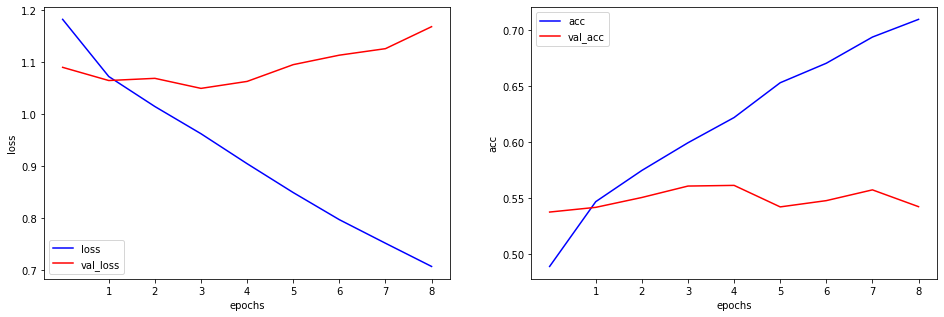

In [ ]:
# ephoc에 따라 loss 함수의 값과 acc의 변화를 보여준다.
metrics=pd.DataFrame({
    'loss':history.history['loss'],
    'val_loss':history.history['val_loss'],
    'acc':history.history['acc'],
    'val_acc':history.history['val_acc']
    })

fig, ax = plt.subplots(1,2,figsize=(16,5))
epochs = es.stopped_epoch+1  # x축 길이 

metrics.loss.plot(color='b',ax=ax[0])
metrics.val_loss.plot(color='r',ax=ax[0])

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_xticks(range(1,epochs,1))
ax[0].legend()

metrics.acc.plot(color='b',ax=ax[1])
metrics.val_acc.plot(color='r',ax=ax[1])

ax[1].set_xlabel('epochs')
ax[1].set_ylabel('acc')
ax[1].set_xticks(range(1,epochs,1))
ax[1].legend()


### 5. 모델 활용(예측/분류)

- 데이터 불러오기: test_df
- 동일한 전처리와 벡터화 적용
- predict


In [ ]:
import pandas as pd

# data_path = '~/Workspaces/keras/dacon-shopping-mall/review_data'
data_path = "/gdrive/MyDrive/Colab Notebooks/제주ICT-AI분석반-쇼핑몰분석/data"

# Okt 토크나이징 데이터 로딩
# ==> NaN, 한글자 제거 (rows=24986)
test_df = pd.read_csv(f'{data_path}/test_okt_stem.csv')
test_df

,id,reviews,mrp_tokens,pos_tokens,mrp_tsize,pos_tsize,pos_csize
0,0,채소가 약간 시들어 있어요,채소 가 약간 시들어 있어요,채소 약간 시들다 있다,5,4,9
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리 고 힘 이 없어서 들어...,발톱 두껍다 단단하다 분들 써다 소용없다 이 테이프 물렁거리 힘 없다 들다 올리다 ...,24,21,50
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋다 입어보다 시원하다 또 살다,6,6,17
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,이런 1 . 8 골드 주 라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하...,이렇다 골드 주 파란 개 오다 회사 전화 걸다 받다 않다 머 하다 임,19,14,25
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수 도 없이 보내구 불량 배송비 5000원 청구 하네요 완전 별로 별하나 도 아까워요,검수 없이 보내다 불량 배송비 청구 하다 완전 별로 별하나 아깝다,14,11,26
...,...,...,...,...,...,...,...
24984,24995,사용해보니 좋아요~^^,사용 해보니 좋아요 ~^^,사용 해보다 좋다,4,3,7
24985,24996,저렴한가격에. 질좋고. 핏좋고. 너무. 이쁘게. 입고다녀요..,저렴한 가격 에 . 질 좋고 . 핏좋 고 . 너무 . 이쁘게 . 입고 다녀요 ..,저렴하다 가격 질 좋다 핏좋 너무 이쁘다 입다 다니다,17,9,21
24986,24997,세트상품이라고 써있어서 그런줄 알고 구매했더니 단품이었네요 낚인 느낌도 들고 그러네...,세트 상품 이라고 써있어서 그런줄 알 고 구매 했더니 단 품 이었네요 낚 인 느낌 ...,세트 상품 써다 그렇다 알 구매 하다 단 품 이다 낚 느낌 들다 그렇다 딘품 표시 ...,40,31,55
24987,24998,역시 로네펠트!! 좋아요.,역시 로 네 펠트 !! 좋아요 .,역시 로 네 펠트 좋다,7,5,8


In [ ]:
# Z_test 에 대해서도 임베딩(시퀀스+패딩) 작업
Z_encoded = tokenizer.texts_to_sequences(test_df['pos_tokens'])
Z_test_vec = tf.keras.preprocessing.sequence.pad_sequences(Z_encoded, maxlen=maxlen_pad, padding='post')

print( Z_test_vec.dtype, np.shape(Z_test_vec) )
# int32, (24988, 30)

int32 (24989, 30)


In [ ]:
# 예측값 생성
pred_cate = loaded_model.predict(Z_test_vec)
print( pred_cate.dtype, np.shape(pred_cate), pred_cate[0] )
# float32 (24989, 5) 
# [4.1685391e-02 2.2301321e-01 4.8615730e-05 2.5124931e-01 4.8400342e-01]


float32 (24989, 5) [1.16146125e-01 4.18494970e-01 2.89156524e-05 1.41663581e-01
 3.23666364e-01]


In [ ]:
# 예측값 후처리: pred_cate => pred_target
# 후처리 예제 np.argmax([0.0, 0.0, 0.0, 0.0, 1.0])+1 => 5 

pred_target = np.array([ np.argmax(cate)+1 for cate in pred_cate ], dtype='int8')
print( pred_target.dtype, np.shape(pred_target), pred_target[0] )

# 예측값 저장
test_df['pred_target'] = pred_target.tolist()
test_df.head()

int8 (24989,) 2


,id,reviews,mrp_tokens,pos_tokens,mrp_tsize,pos_tsize,pos_csize,pred_target
0,0,채소가 약간 시들어 있어요,채소 가 약간 시들어 있어요,채소 약간 시들다 있다,5,4,9,2
1,1,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리고 힘이없어서 들어 올리...,발톱 두껍고 단단한 분들 써도 소용없어요 이 테이프 물렁거리 고 힘 이 없어서 들어...,발톱 두껍다 단단하다 분들 써다 소용없다 이 테이프 물렁거리 힘 없다 들다 올리다 ...,24,21,50,2
2,2,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋네요 입어보고 시원하면 또 살게요,부들부들 좋다 입어보다 시원하다 또 살다,6,6,17,5
3,3,이런 1. 8 골드 주라니깐 파란개 오네 회사전화걸어도 받지도 않고 머하자는거임?,이런 1 . 8 골드 주 라니깐 파란 개 오네 회사 전화 걸어도 받지도 않고 머 하...,이렇다 골드 주 파란 개 오다 회사 전화 걸다 받다 않다 머 하다 임,19,14,25,2
4,4,검수도 없이 보내구 불량 배송비 5000원 청구하네요 완전별로 별하나도 아까워요,검수 도 없이 보내구 불량 배송비 5000원 청구 하네요 완전 별로 별하나 도 아까워요,검수 없이 보내다 불량 배송비 청구 하다 완전 별로 별하나 아깝다,14,11,26,1


### 6. 모델 시각화 (실제값/예측값)

- 예측값 시각화
- 실제값 시각화


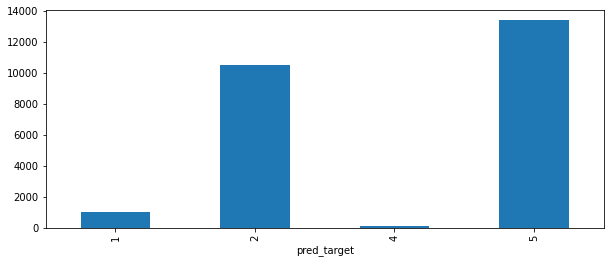

In [ ]:
# 예측값
test_df.groupby('pred_target').count()['id'].plot.bar(figsize=(10,4))

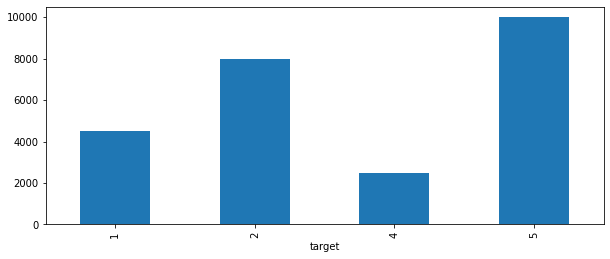

In [ ]:
# 훈련용 실제값
train_df.groupby('target').count()['id'].plot.bar(figsize=(10,4))